# Packages

Import required packages

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import normalize

# Load Data

Here we load and preprocess data from CSV file

In [9]:
df_file_loc = "../data/2015/SWaT_Dataset_Attack_v0.csv"

df = pd.read_csv(df_file_loc)
print(df.shape)
df_total_rows = int(df.shape[0])

# Dataset Start Time and End Time
df_time_start = 0
df_time_end = 0

for index, row in df.iterrows():
    if index == 1:
        timestamp, _ = normalize.date_time(row["Timestamp"])
        print("timestamp_start=%s" %(timestamp))
        df_time_start = np.array(timestamp, dtype=np.datetime64)
    
    if index == df_total_rows-2:
        timestamp, _ = normalize.date_time(row["Timestamp"])
        print("timestamp_end=%s" %(timestamp))
        df_time_end = np.array(timestamp, dtype=np.datetime64)

df.reset_index()
df.head()

(449919, 53)
timestamp_start=2015-12-28T10:00:01

timestamp_end=2016-01-02T02:59:58



,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
1,28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
2,28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
3,28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
4,28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal


## Detect anomalies from input data

We can get the information about attacks from SWaT dataset `data/2015/List_of_attacks_Final.xlsx. They represent are divided into groups:

- Single stage single point (SSSP)
- Single stage multi point (SSMP)
- Multi stage single point (MSSP)
- Multi stage multi point attacks (MSMP)
 

In [16]:
attacks_file_loc = "../data/2015/List_of_attacks_Final.xlsx"
xlsx = pd.read_excel(attacks_file_loc, sheet_name="Sheet1")

anomalies = []
times = []

for index, row in xlsx.iterrows():
    try:
        # skip if there is no attack
        try:
            tmp = int(row["Attack #"])
        except:
            continue

        # skip if there is no attack
        tmp = row["Attack Point"].split(",")
        if row["Attack Point"] == "No Physical Impact Attack":
            continue

        # extract attack start time
        time_start, time_start_date = normalize.date_time(row["Start Time"])

        # extract attack end time
        time_end = str(row["End Time"])
        time_end = "%sT%s" %(time_start_date, time_end)

        # extract attack points
        attack_points = {}
        for i in tmp:
            i = i.strip(" ")
            i = i.upper()
            i = i.replace("-", "")
            attack_points[i] = ""
        attack_points = list(attack_points.keys())

        # define anomaly
        anomaly = {
            "time_start": np.array(time_start, dtype=np.datetime64),
            "time_end": np.array(time_end, dtype=np.datetime64),
            "attack_points": attack_points,
        }
        times.append(np.array(time_start, dtype=np.datetime64))
        times.append(np.array(time_end, dtype=np.datetime64))

        anomalies.append(anomaly)
    except:
        print("Error: %s" %(str(sys.exc_info())))
        print("Row value: %s" %(row))
        print("Index: %d" %(index))

times.sort()
total_time_start = times[0]
total_time_end = times[len(times)-1]

print("Loaded %d anomalies\n" %(len(anomalies)))
print("total_time_start=%s" %(total_time_start))
print("total_time_end=%s" %(total_time_end))


Loaded 36 anomalies

total_time_start=2015-12-28T10:29:14
total_time_end=2016-01-02T13:40:56


## Plot all

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


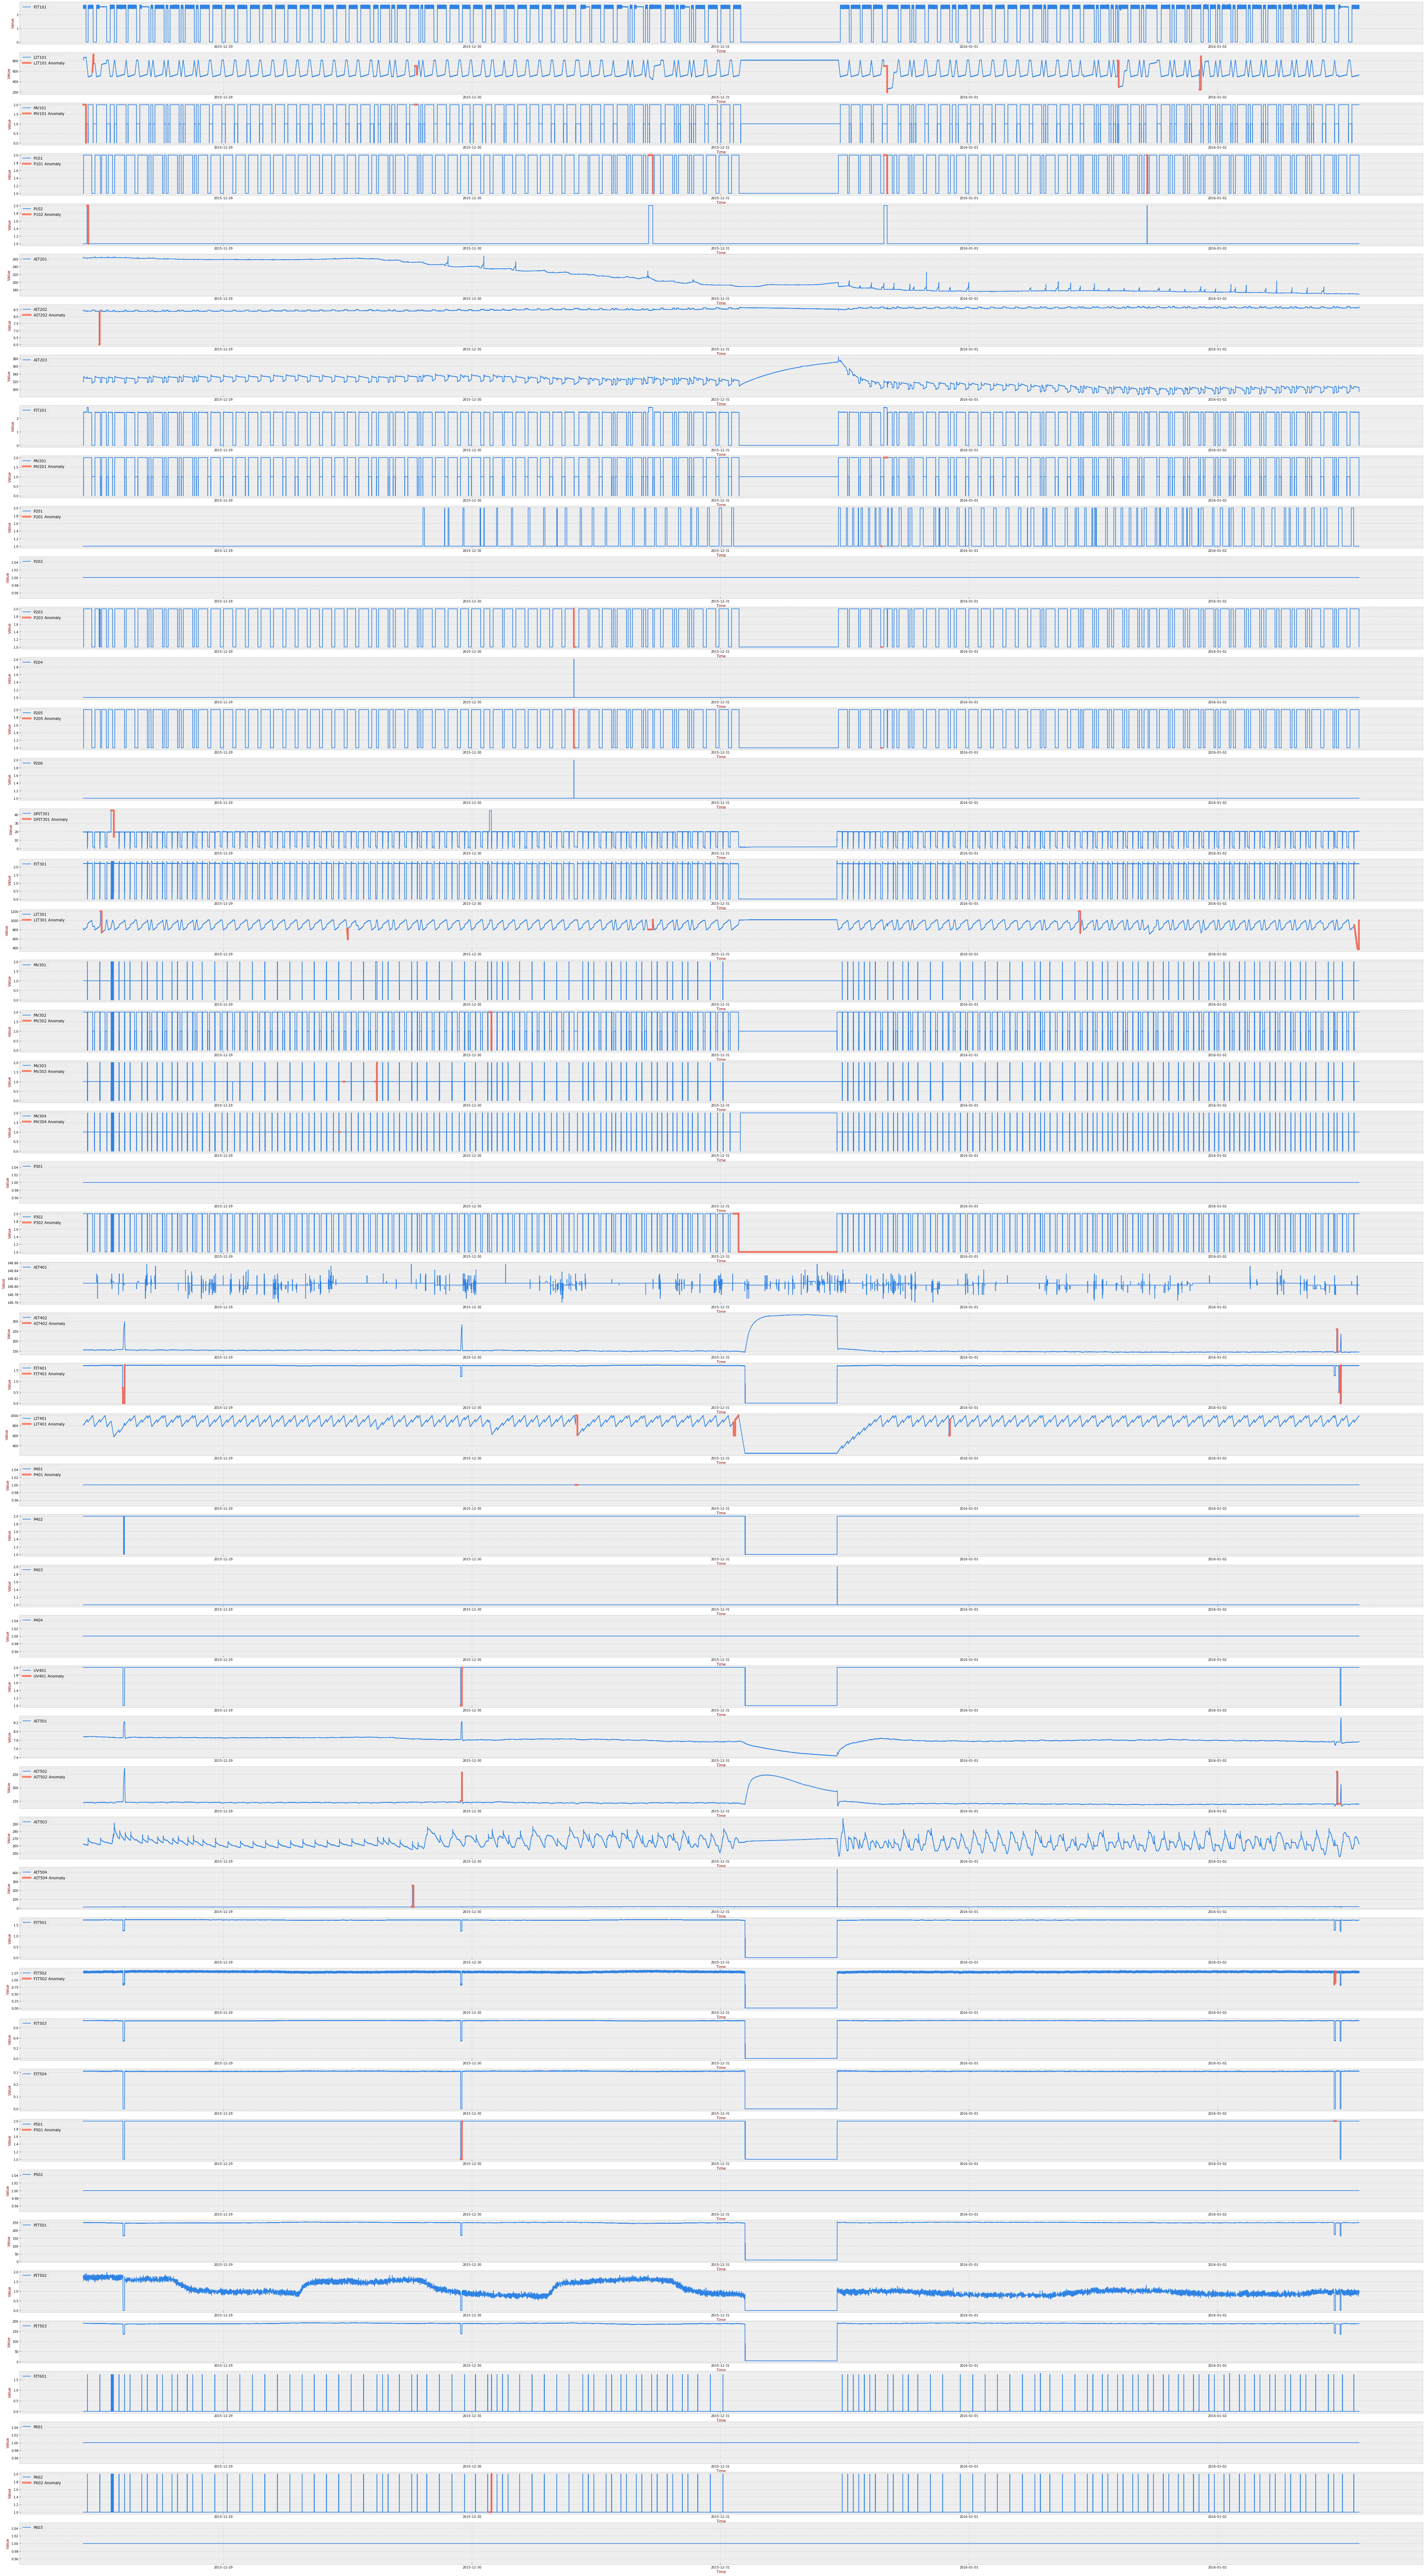

In [20]:
# Visualization Start Time and End Time
time_delta = np.timedelta64(1, 's')
time_len = int((total_time_end - total_time_start) / time_delta)

x = total_time_start + np.arange(0, time_len, 1)
idx_start = int((total_time_start - df_time_start) / time_delta)
idx_end = int((total_time_end - df_time_start) / time_delta)

total_columns = int(df.shape[1])-2
font_family = "verdana"
color_anomaly = "tomato"
color_default = "#2f83e4"

with plt.style.context("bmh"):
    font = {
        "color": "darkred", 
        "size": 12, 
        "family": font_family
    }
    font_legend = {
        "size": 12, 
        "family": font_family
    }

    fig, axs = plt.subplots(total_columns, 1, figsize=(80, 150))

    anomaly_label_indexes = {}

    for i in range(total_columns):
        axs[i].plot(x, df.iloc[idx_start:idx_end, i+1], label=df.columns[i+1], color=color_default)

        axs[i].set_xlabel("Time", fontdict=font)
        axs[i].set_ylabel("Value", fontdict=font)
        axs[i].legend(loc="upper left", prop=font_legend)
        labels = axs[i].get_xticklabels() + axs[i].get_yticklabels()
        [ label.set_fontname(font_family) for label in labels ]

        for anomaly in anomalies:
            if df.columns[i+1] not in anomaly["attack_points"]:
                continue

            anomaly_idx = anomaly["time_start"] + np.arange(0, int((anomaly["time_end"] - anomaly["time_start"])/time_delta), 1)
            
            anomaly_idx_start = int((anomaly["time_start"] - total_time_start)/time_delta)
            anomaly_idx_end = int((anomaly["time_end"] - total_time_start)/time_delta)
            
            loc = df.iloc[idx_start + anomaly_idx_start:idx_start + anomaly_idx_end, i+1]

            if df.columns[i+1] not in anomaly_label_indexes:
                label = '{} Anomaly'.format(df.columns[i+1])
                axs[i].plot(anomaly_idx, loc, label=label, color=color_anomaly, linewidth=6, alpha=0.8)
                axs[i].legend(loc="upper left", prop=font_legend)

                anomaly_label_indexes[df.columns[i+1]] = ""
            else:
                axs[i].plot(anomaly_idx, loc, color=color_anomaly, linewidth=6, alpha=0.8)

plt.savefig('../output/swat_all.png')